In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- 1. Load your full-year daily data with date parsing ---
df = pd.read_csv(r'C:\Users\Jouke\Documents\evedata-logger\output\update_2025-07-13.csv', parse_dates=['date'])

In [3]:
# --- 2. Aggregate to average daily volume/price per item over the year ---
annual_summary = df.groupby('type_name').agg(
    avg_daily_volume=('volume', 'mean'),
    avg_daily_price=('average', 'mean'),
    num_days=('date', 'nunique')
).reset_index()

annual_summary['avg_daily_isk_flow'] = annual_summary['avg_daily_volume'] * annual_summary['avg_daily_price']

In [4]:
# --- 3. Categorize by liquidity based on avg_daily_volume ---
def liquidity_category(volume):
    if volume > 1_000_000_000:
        return 'Ultra-liquid'
    elif volume > 100_000_000:
        return 'High liquidity'
    elif volume > 10_000_000:
        return 'Medium'
    else:
        return 'Low'

annual_summary['liquidity_category'] = annual_summary['avg_daily_volume'].apply(liquidity_category)

In [5]:
# --- 4. Summarize per category ---
summary = annual_summary.groupby('liquidity_category').agg(
    total_liquidity=('avg_daily_volume', 'sum'),
    num_items=('type_name', 'nunique'),
    total_isk_flow=('avg_daily_isk_flow', 'sum')
).reset_index()

summary = summary.sort_values('total_liquidity', ascending=False)
summary['percent_of_total_liquidity'] = 100 * summary['total_liquidity'] / summary['total_liquidity'].sum()
summary['percent_of_total_isk_flow'] = 100 * summary['total_isk_flow'] / summary['total_isk_flow'].sum()
summary['total_isk_flow_bil'] = summary['total_isk_flow'] / 1e9

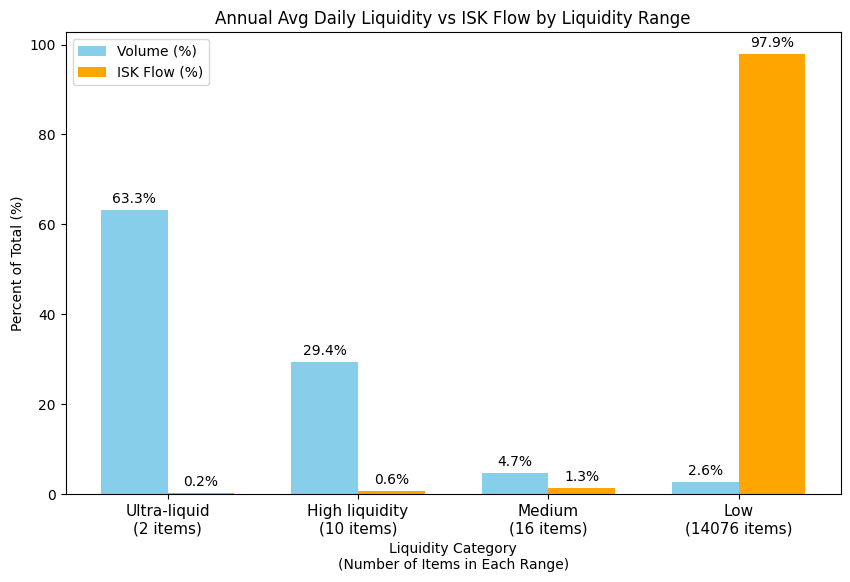

In [6]:
# --- 5. Plot as in your code ---
labels = [f"{cat}\n({n} items)" for cat, n in zip(summary['liquidity_category'], summary['num_items'])]
x = np.arange(len(labels))
width = 0.35

volumes = summary['percent_of_total_liquidity']
isk_flows = summary['percent_of_total_isk_flow']

fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width/2, volumes, width, label='Volume (%)', color='skyblue')
rects2 = ax.bar(x + width/2, isk_flows, width, label='ISK Flow (%)', color='orange')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
autolabel(rects1)
autolabel(rects2)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel('Percent of Total (%)')
ax.set_xlabel('Liquidity Category\n(Number of Items in Each Range)')
ax.set_title('Annual Avg Daily Liquidity vs ISK Flow by Liquidity Range')

ax.legend(loc='upper left')

In [7]:
# --- ISK flow legend (actual numbers) ---
isk_legend_lines = []
for idx, row in summary.iterrows():
    cat = row['liquidity_category']
    isk_val = row['total_isk_flow_bil']
    isk_legend_lines.append(f"{cat}: {isk_val:,.0f} B ISK")
isk_legend_text = "ISK Flow by Range:   " + "   |   ".join(isk_legend_lines)
plt.gcf().text(
    0.5, 1.11,
    isk_legend_text,
    fontsize=10,
    ha='center', va='top',
    bbox=dict(facecolor='white', alpha=0.85, edgecolor='gray')
)

# --- Liquidity range legend just below ---
liquidity_legend = (
    "Liquidity Ranges:\n"
    "Ultra-liquid: > 1B units/day  |  High: 100M–1B  |  Medium: 10M–100M  |  Low: < 10M"
)
plt.gcf().text(
    0.5, 1.07,
    liquidity_legend,
    fontsize=9,
    ha='center', va='top',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

<Figure size 640x480 with 0 Axes>

In [8]:
# --- 6. Print the items for each liquidity range (all except Low, top 20 for Low) ---
display_columns = ['type_name', 'avg_daily_volume', 'avg_daily_price', 'avg_daily_isk_flow']

print("\n=== Items in Each Liquidity Range ===\n")

# Ultra-liquid, High, and Medium: show all items
for cat in ['Ultra-liquid', 'High liquidity', 'Medium']:
    items = annual_summary[annual_summary['liquidity_category'] == cat]
    if not items.empty:
        print(f"\n--- {cat} ({len(items)} items) ---")
        display_df = items.sort_values('avg_daily_isk_flow', ascending=False)[display_columns]
        print(display_df.to_string(index=False, formatters={
            'avg_daily_volume': '{:,.0f}'.format,
            'avg_daily_price': '{:,.2f}'.format,
            'avg_daily_isk_flow': '{:,.0f}'.format
        }))

# Low: show top 20 by ISK flow
low_items = annual_summary[annual_summary['liquidity_category'] == 'Low']
if not low_items.empty:
    print(f"\n--- Low (showing top 20 of {len(low_items)} items by ISK flow) ---")
    display_df = low_items.sort_values('avg_daily_isk_flow', ascending=False).head(20)[display_columns]
    print(display_df.to_string(index=False, formatters={
        'avg_daily_volume': '{:,.0f}'.format,
        'avg_daily_price': '{:,.2f}'.format,
        'avg_daily_isk_flow': '{:,.0f}'.format
    }))


=== Items in Each Liquidity Range ===


--- Ultra-liquid (2 items) ---
type_name avg_daily_volume avg_daily_price avg_daily_isk_flow
  Pyerite    2,737,412,274           19.43     53,189,795,418
Tritanium    5,236,436,238            4.44     23,272,874,603

--- High liquidity (10 items) ---
                       type_name avg_daily_volume avg_daily_price avg_daily_isk_flow
                          Isogen      235,344,595          350.97     82,598,150,886
                        Mexallon      639,062,977           91.17     58,260,237,556
             Compressed Veldspar      830,438,344           12.87     10,684,328,729
Compressed Concentrated Veldspar      688,161,899           13.17      9,060,735,487
          Compressed Plagioclase      135,592,186           54.63      7,407,129,952
             Compressed Scordite      300,613,023           24.05      7,230,113,826
    Compressed Azure Plagioclase      120,323,235           55.25      6,647,258,751
   Compressed Condensed Sco

In [9]:
# --- Market share by daily annual average ISK flow ---

# 1. Total market average daily ISK flow (all items in annual_summary)
total_market_daily_isk_flow = annual_summary['avg_daily_isk_flow'].sum()

# 2. ISK flow for the three items (use your numbers here, or get from annual_summary)
three_items = [
    ("PLEX", 5_586_521_171_214),
    ("Large Skill Injector", 2_683_740_862_684),
    ("Skill Extractor", 1_579_334_257_772)
]

print("\n--- Market share by annual avg daily ISK flow ---")
total_share = 0
total_isk = 0
for name, isk_flow in three_items:
    share = 100 * isk_flow / total_market_daily_isk_flow
    total_share += share
    total_isk += isk_flow
    print(f"{name:22s} : {isk_flow:,.0f} ISK/day   |   {share:6.2f}% of market")

print(f"\nCombined total for all 3 items: {total_isk:,.0f} ISK/day   |   {total_share:6.2f}% of market")

# Optionally, show the total market ISK flow
print(f"\nTotal market average daily ISK flow: {total_market_daily_isk_flow:,.0f} ISK/day")



--- Market share by annual avg daily ISK flow ---
PLEX                   : 5,586,521,171,214 ISK/day   |    17.44% of market
Large Skill Injector   : 2,683,740,862,684 ISK/day   |     8.38% of market
Skill Extractor        : 1,579,334,257,772 ISK/day   |     4.93% of market

Combined total for all 3 items: 9,849,596,291,670 ISK/day   |    30.75% of market

Total market average daily ISK flow: 32,036,002,607,798 ISK/day
